In [85]:
import re
import sys
import json
import numpy as np
from datetime import date
import requests
import pandas as pd
import psycopg2
from loguru import logger
import traceback

In [86]:
curve = pd.read_csv('txposturecurve.csv')

In [87]:
test = ['Caso prueba 1','Optimizacion 1']

nombre = test[1]

In [88]:
reproductoras = pd.read_excel('casos de prueba.xlsx', sheet_name=nombre)

In [89]:
reproductoras.set_index('Recepcion calculada', inplace=True)

In [90]:
reproductoras

,Raza,encasetadas
Recepcion calculada,,
2017-06-25,ROSS,17835
2017-07-02,ROSS,40000
2017-07-30,ROSS,11679
2017-09-03,ROSS,11368
2017-11-12,ROSS,10000
2018-03-04,ROSS,40000
2018-03-11,ROSS,38625
2018-03-18,ROSS,10000
2018-04-08,ROSS,10000


In [91]:
date_init = '2017-01-01'
date_end = '2020-01-01'

In [92]:
posture = np.flip(curve["theorical_performance"])
daterange = pd.date_range(start=pd.Timestamp(date_init), end=pd.Timestamp(date_end),freq='D')
reproductoras = reproductoras.reindex(daterange, fill_value=0)
reproductoras = reproductoras.resample('W').agg({'encasetadas': 'sum'})
matriz = np.zeros((len(reproductoras),len(reproductoras)))


for i in range(0,len(reproductoras)):
    for j in range(i,i + len(posture)):
        if (j < len(reproductoras)):
            matriz[j,i]=posture[j-i]
# np.savetxt("matriz.csv", self.matriz, delimiter=",")
production = np.dot(
    matriz,
    reproductoras["encasetadas"]
)

In [93]:
production

array([     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,   3567.  ,  48663.8 , 171635.85, 276352.3 , 316502.8 ,
       332087.05, 359536.07, 384953.44, 391735.82, 394126.12, 394725.5 ,
       415177.72, 435680.64, 442962.26, 442300.35, 438020.41, 434421.7 ,
       429261.6 , 422780.47, 415847.84, 412425.39, 428083.55, 444355.78,
       445757.63, 440438.34, 434577.45, 429786.37, 421771.66, 414445.02,
       406824.09, 398826.11, 388309.14, 381946.55, 373761.46, 365249.86,
       357390.88, 357605.17, 435284.07, 535322.9 , 550812.89, 615132.97,
       637553.7 , 659080.26, 641327.85, 644728.41, 643419.04, 638323.56,
       628440.87, 586423.75, 581178.75, 573147.5 , 566071.25, 559540.  ,
       551708.75, 542046.25, 532183.75, 524093.75, 

In [94]:
reproductoras.loc[reproductoras["encasetadas"] > 0]

,encasetadas
2017-06-25,17835
2017-07-02,40000
2017-07-30,11679
2017-09-03,11368
2017-11-12,10000
2018-03-04,40000
2018-03-11,38625
2018-03-18,10000
2018-04-08,10000


In [95]:
matriz

array([[0.2 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [2.28, 0.2 , 0.  , ..., 0.  , 0.  , 0.  ],
       [4.51, 2.28, 0.2 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.2 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 2.28, 0.2 , 0.  ],
       [0.  , 0.  , 0.  , ..., 4.51, 2.28, 0.2 ]])

In [96]:
reproductoras.loc[reproductoras["encasetadas"] > 0]

,encasetadas
2017-06-25,17835
2017-07-02,40000
2017-07-30,11679
2017-09-03,11368
2017-11-12,10000
2018-03-04,40000
2018-03-11,38625
2018-03-18,10000
2018-04-08,10000


In [97]:
reproductoras["encasetadas"]

2017-01-01    0
2017-01-08    0
2017-01-15    0
2017-01-22    0
2017-01-29    0
             ..
2019-12-08    0
2019-12-15    0
2019-12-22    0
2019-12-29    0
2020-01-05    0
Freq: W-SUN, Name: encasetadas, Length: 158, dtype: int64

In [98]:
reproductoras["encasetadas"].shape

(158,)

In [99]:
urlGoalsResults = 'http://127.0.0.1:3009/scenario_param/getParameterGoal'
res = requests.post(urlGoalsResults, 
json={
    "scenario_id": 4,
    "filter_breed" : [2],
    "filter_stage" : []
    }
)
data_to_erp = pd.DataFrame(res.json()["data_to_erp"]).dropna()
data_to_erp = data_to_erp[["fecha","value","breed_id","product_id"]]
data_to_erp["breed_id"] = data_to_erp["breed_id"].astype(int)
data_to_erp["product_id"] = data_to_erp["product_id"].astype(int)
data_to_erp["fecha"]  = pd.to_datetime(data_to_erp.fecha, dayfirst=True)
data_to_erp.rename(columns={"value":"demand"},inplace=True)
data_to_erp.to_csv("data_to_erp.csv")
data_to_erp = data_to_erp.loc[(data_to_erp.breed_id == 2) & (data_to_erp.product_id == 2)]
data_to_erp = data_to_erp.drop_duplicates(subset=["fecha"], keep="last")
data_to_erp.set_index("fecha", inplace=True)
daterange = pd.date_range(start=pd.Timestamp(date_init), end=pd.Timestamp(date_end),freq='D')
data_to_erp = data_to_erp.reindex(daterange, fill_value=0)
data_to_erp = data_to_erp.resample('W').agg({'demand': 'sum'})


In [100]:
data_to_erp

,demand
2017-01-01,0
2017-01-08,0
2017-01-15,0
2017-01-22,0
2017-01-29,0
...,...
2019-12-08,0
2019-12-15,0
2019-12-22,0
2019-12-29,0


In [101]:
data_to_erp["production"] = production

In [102]:
dif = []
difnro = []
dif = production.copy()
demanda = data_to_erp["demand"].copy()

totalresidue = production - demanda
residue = np.roll(totalresidue, 1)
residue[0] = 0
residue[residue < 0] = 0
totalresidue[totalresidue < 0] = 0
production = production + residue - totalresidue
difnro = production - demanda
dif[demanda!=0] = (((production[demanda!=0]-demanda[demanda!=0])/demanda[demanda!=0]))*100

In [103]:
residue

array([0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3567.0,
       48663.799999999996, 171635.84999999998, 276352.3, 316502.8,
       332087.05, 359536.07, 384953.44, 391735.82, 394126.12, 394725.5,
       415177.72, 435680.64, 442962.25999999995, 442300.35, 438020.41,
       434421.69999999995, 429261.6, 422780.47, 353972.83999999997, 0, 0,
       11230.780000000028, 12632.630000000005, 2658.3399999999674, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55045.89999999991,
       70535.89000000001, 134855.96999999997, 147516.69999999995,
       162233.26, 144684.84999999986, 148085.41000000003,
       152540.04000000004, 161652.56000000006, 151264.87, 109247.75,
       104002.75, 80371.5, 71402.25, 64871.0, 57039.75, 40612.25,
       21729.75, 13639.75, 3922.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 326382.25, 307745.5, 169299.25, 45848.0, 14048.0, 28128.0,
       30900.0, 0.0, 0.0, 0.0, 

In [104]:
result = pd.DataFrame(columns=["dates","diferenceNro","difference","production","demand","lot_size","isPrevios"])
result["dates"] = data_to_erp.index
result["diferenceNro"] = difnro.tolist()
result["difference"] = dif.tolist()
result["production"] = production.tolist()
result["demand"] = demanda.tolist()
result["lot_size"] = reproductoras["encasetadas"].astype(int).tolist()


In [105]:
difnro

2017-01-01    0.0
2017-01-08    0.0
2017-01-15    0.0
2017-01-22    0.0
2017-01-29    0.0
             ... 
2019-12-08    0.0
2019-12-15    0.0
2019-12-22    0.0
2019-12-29    0.0
2020-01-05    0.0
Freq: W-SUN, Name: demand, Length: 158, dtype: object

In [106]:
result

,dates,diferenceNro,difference,production,demand,lot_size,isPrevios
0,2017-01-01,0.0,0.0,0.0,0,0,NaN
1,2017-01-08,0.0,0.0,0.0,0,0,NaN
2,2017-01-15,0.0,0.0,0.0,0,0,NaN
3,2017-01-22,0.0,0.0,0.0,0,0,NaN
4,2017-01-29,0.0,0.0,0.0,0,0,NaN
...,...,...,...,...,...,...,...
153,2019-12-08,0.0,0.0,0.0,0,0,NaN
154,2019-12-15,0.0,0.0,0.0,0,0,NaN
155,2019-12-22,0.0,0.0,0.0,0,0,NaN
156,2019-12-29,0.0,0.0,0.0,0,0,NaN


In [107]:
result.to_csv(f"""test result {nombre}.csv""")

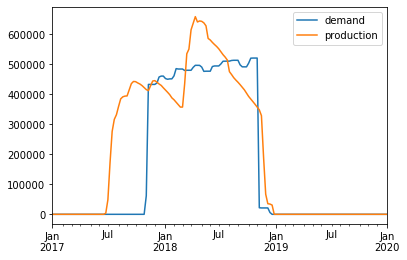

In [108]:
#plot the curve x and y curves
import matplotlib.pyplot as plt
data_to_erp.to_csv("data_to_erp.csv")
data_to_erp[["demand","production"]].plot()



In [109]:
daterange

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', length=1096, freq='D')